Files already downloaded and verified


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Files already downloaded and verified


Starting Training Loop...
reset epoch statistics
iteration 0 current loss: 2.3094465732574463 current acc: 0.0625
iteration 1 current loss: 2.306140899658203 current acc: 0.078125
iteration 2 current loss: 2.300158739089966 current acc: 0.09114583333333333
iteration 3 current loss: 2.3068268299102783 current acc: 0.08203125
iteration 4 current loss: 2.299855947494507 current acc: 0.078125
iteration 5 current loss: 2.2854812145233154 current acc: 0.0859375
iteration 6 current loss: 2.2806763648986816 current acc: 0.09151785714285714
iteration 7 current loss: 2.282819986343384 current acc: 0.0986328125
iteration 8 current loss: 2.2855989933013916 current acc: 0.10069444444444445
iteration 9 current loss: 2.2773733139038086 current acc: 0.10234375
iteration 10 current loss: 2.2677764892578125 current acc: 0.109375
iteration 11 current loss: 2.2744452953338623 current acc: 0.11328125
iteration 12 current loss: 2.269927978515625 current acc: 0.11598557692307693
iteration 13 current loss: 2.

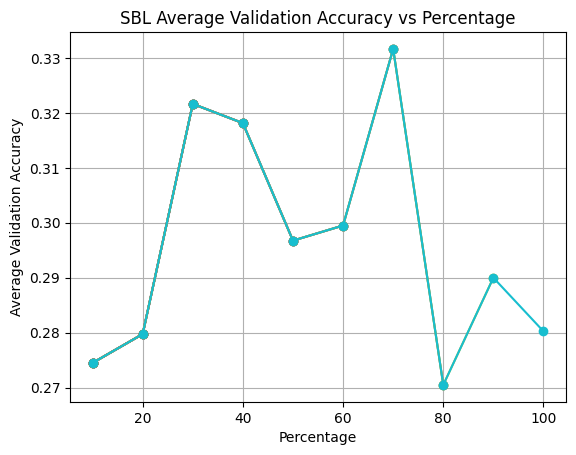

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import wandb



learning_rate = 0.0001 #best lr found in fthps
batch_size = 128 #best bs found in fthps
weight_decay = 0.0004 #best wd found in fthps

batch_size = batch_size
image_size = 96

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


train_dataset = STL10(root='./data', split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = STL10(root='./data', split='test', transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


num_train = len(train_dataset)
nc = 3
ndf = 96
num_epochs = 1
lr=learning_rate
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z, num_classes):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )
        self.fc = nn.Linear(dim_z, num_classes)

    def forward(self, input):
        z = self.main(input)
        z = z.view(input.size(0), -1)  # Flatten z to (batch_size, dim_z)
        c = self.fc(z)
        return c


# set up wandb
wandb.login()

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="dcgan-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "architecture": "FT Percentages",
    "dataset": "STL-10",
    "epochs": num_epochs,
    }
)

# Lists to store data for plotting
percentages = []
avg_val_accs = []

# Training loop for different percentages of labeled data
for percent in range(10, 101, 10):  # Train on 10%, 20%, ..., 100% of the labeled data
    # Calculate the number of samples to use
    num_samples = int(num_train * percent / 100)
    
    # Create a subset of the dataset with the desired percentage
    subset_train_dataset = torch.utils.data.Subset(train_dataset, indices=range(num_samples))
    subset_train_loader = DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)

    # Load Pretrained Weights
    encoder = Encoder(ngpu=0, dim_z=64, num_classes=10).to(device)
    PATH='/data/users2/jwardell1/dcgan-project/models/ae_pretraining_0.0001_256_0.0004.pth'
    encoder.main.load_state_dict(torch.load(PATH))
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(encoder.parameters(), lr=lr, weight_decay=weight_decay)

    
    
    best_loss = float('inf')
    best_model_state = None
    num_train = len(train_dataset)
    
    all_loss = []
    all_acc = []
    all_correct = 0
    train_running_total = 0
    
    epoch_loss = []
    epoch_acc = []
    
    val_loss = []
    val_acc = []
    val_running_total = 0
        

    print("Starting Training Loop...")
    
    # For each epoch
    for epoch in range(num_epochs):
        # Refresh Epoch Statistics
        print('reset epoch statistics')
        epoch_correct = 0
        epoch_loss_val = 0
    
    
        # Set Network to Train Mode
        encoder.train()
    
    
        # For each batch in the dataloader
        for i, (data, labels) in enumerate(train_loader, 0):
            # Put train data to device (CPU, GPU, or TPU)
            data_real = data.to(device)
            labels = labels.to(device)
    
            #  what does this do? why is this needed here?
            optimizer.zero_grad()
    
            # Forward pass batch through D
            output = encoder(data_real)
    
    
            # Calculate loss on batch
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
    
    
            # Compute Predicted Labels for a Batch in Training Dataset
            predicted = torch.argmax(output.data, dim=1).to(device)
    
    
    
            correct = (predicted == labels).sum().item()
    
    
    
    
    
    
            # Update All Data
            all_loss.append(loss.item())
    
            all_correct += correct
            train_running_total += labels.size(0)
    
    
            # Compute All Loss/Acc at each datapoint
            all_accuracy = all_correct / train_running_total
            all_acc.append(all_accuracy)
    
            print(f'iteration {i} current loss: {loss.item()} current acc: {all_accuracy}')
    
    
            # Update Epoch Data
            epoch_correct += correct
            epoch_loss_val += loss.item()
    
    
        wandb.log({"TrainLoss": loss.item()})
        wandb.log({"TrainAccuracy": all_accuracy})
        
        # Compute Epoch Loss/Acc at end of Epoch
        epoch_accuracy = epoch_correct / num_train
        epoch_acc.append(epoch_accuracy)
    
        avg_epoch_loss = epoch_loss_val / len(train_loader)
        epoch_loss.append(avg_epoch_loss)
    
        print(f'\t\tEpoch {epoch}/{num_epochs} complete. Epoch loss {avg_epoch_loss} Epoch accuracy {epoch_accuracy}')
    
        # Validation Step
        print('Starting Validation Loop...')
    
    
    
        # Refresh Validation Statistics
        print('reset Validation statistics')
        val_correct = 0
        val_loss_value = 0
    
    
        # Set the model to valuation mode
        encoder.eval()
    
    
        # Iterate over the validation dataset in batches
        with torch.no_grad():
            for data, labels in test_loader:
    
                # Put val data to device (CPU, GPU, or TPU)
                data_real = data.to(device)
                labels = labels.to(device)
    
    
                # Forward pass batch through D
                output = encoder(data_real)
    
                # Calculate loss on validation batch
                v_loss = criterion(output, labels)
    
                # Compute Predicted Labels for a Batch in Validation Dataset
                predicted = torch.argmax(output.data, dim=1).to(device)
                val_correct += (predicted == labels).sum().item()
    
                # Update Val Data
                val_loss_value += v_loss.item()
    
    
    
        val_accuracy = val_correct / len(test_dataset)
        val_acc.append(val_accuracy)
        wandb.log({"ValidationAccuracy": val_accuracy})
    
        
        avg_val_loss = val_loss_value / len(test_loader)
        val_loss.append(avg_val_loss)
    
        print(f"\t\tValidation Epoch {epoch}, Validation Accuracy: {val_accuracy}, Validation Loss: {avg_val_loss}")
        wandb.log({"ValidationLoss": val_loss_value})
    
        # Update best model if this epoch had the higest accuracy so far
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            print(f'best loss {best_loss}')
            best_model_state = encoder.main.state_dict()


    
    # Record avg val acc across all epochs for each percent
    percentages.append(percent)
    avg_val_accs.append(sum(val_acc) / len(val_acc))
    print(f'percent {percent}')
    print(f'avg val acc {sum(val_acc) / len(val_acc)}')

    plt.plot(percentages, avg_val_accs, marker='o')
    plt.xlabel('Percentage')
    plt.ylabel('Average Validation Accuracy')
    plt.title('SBL Average Validation Accuracy vs Percentage')
    plt.grid(True)
    plt.savefig('../models/ft_acc_per.png')
    np.save('../models/ft_avg_val_accs_{}_{}_{}.npy'.format(learning_rate, batch_size, weight_decay), avg_val_accs)
    
    # Save the best model
    if best_model_state is not None:
        PATH = '../models/finetuned_encoder_weights_{}_{}_{}.pth'.format(learning_rate, batch_size, weight_decay)
        torch.save(best_model_state, PATH)

In [5]:
wandb.finish()

TrainAccuracy,▁▃▄▇▂▃▃▄█▃
TrainLoss,▃▅▁▇▃▄█▃▃▄
ValidationAccuracy,▁▂▇▆▄▄█▁▃▂
ValidationLoss,▂█▄▃▂█▂▃▃▁
TrainAccuracy,0.216
TrainLoss,2.06191
ValidationAccuracy,0.28025
ValidationLoss,124.26082
